In [84]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

## Data visualization

In [85]:
all_df = pd.read_excel("./Dataset/trainDataset.xls", sheet_name="Sheet1")

all_df.info()
all_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 120 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(11), object(1)
memory usage: 375.1+ KB


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000
mean,12.727500,56.159792,51.851171,0.540000,2.900000,2.81000,2.830000,9.880000,6.577500,8.625000,...,3.945420e-01,3.899257e-01,2.711993e+00,0.003314,5.683152e+07,176.969142,32500.032680,0.056721,0.005948,0.029385
std,111.104111,26.763774,10.864462,0.499022,49.932235,49.93649,49.935558,86.092482,70.443308,86.200962,...,1.674769e-01,1.624792e-01,7.556631e-01,0.002412,7.063822e+08,1045.305721,177545.921557,0.047363,0.008416,0.115909
min,0.000000,5.000000,23.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,0.000000,38.000000,44.616016,0.000000,0.000000,0.00000,0.000000,2.000000,1.000000,1.000000,...,3.199017e-01,3.175584e-01,2.330664e+00,0.001334,1.078546e+06,18.628013,0.001851,0.018628,0.000310,0.001535
50%,0.000000,55.041667,51.119781,1.000000,0.000000,0.00000,0.000000,2.000000,1.000000,1.000000,...,4.095627e-01,4.054695e-01,2.807355e+00,0.002888,3.366594e+06,66.507214,0.004399,0.047029,0.002301,0.003384
75%,1.000000,73.000000,60.000000,1.000000,1.000000,1.00000,1.000000,3.000000,2.000000,1.000000,...,5.000660e-01,4.962633e-01,3.277613e+00,0.004707,9.231697e+06,154.300334,0.013846,0.084418,0.007873,0.009558
max,999.000000,144.000000,79.603012,1.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


<AxesSubplot:ylabel='RelapseFreeSurvival (outcome)'>

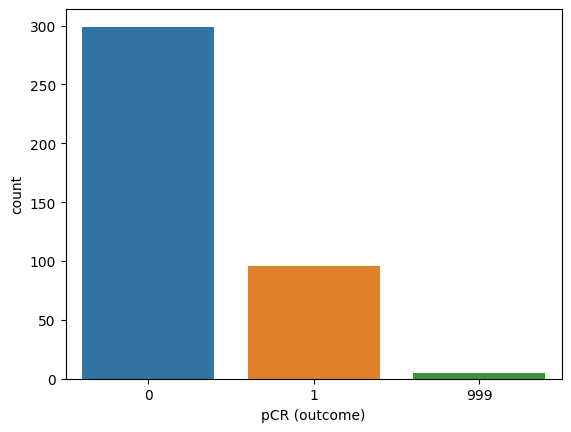

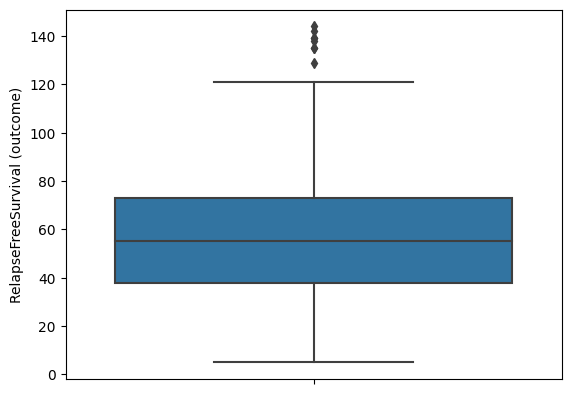

In [86]:
# countplot and boxplot for both classification and regression outcome
sns.countplot(x="pCR (outcome)", data=all_df)
plt.figure()
sns.boxplot(y='RelapseFreeSurvival (outcome)', data=all_df)

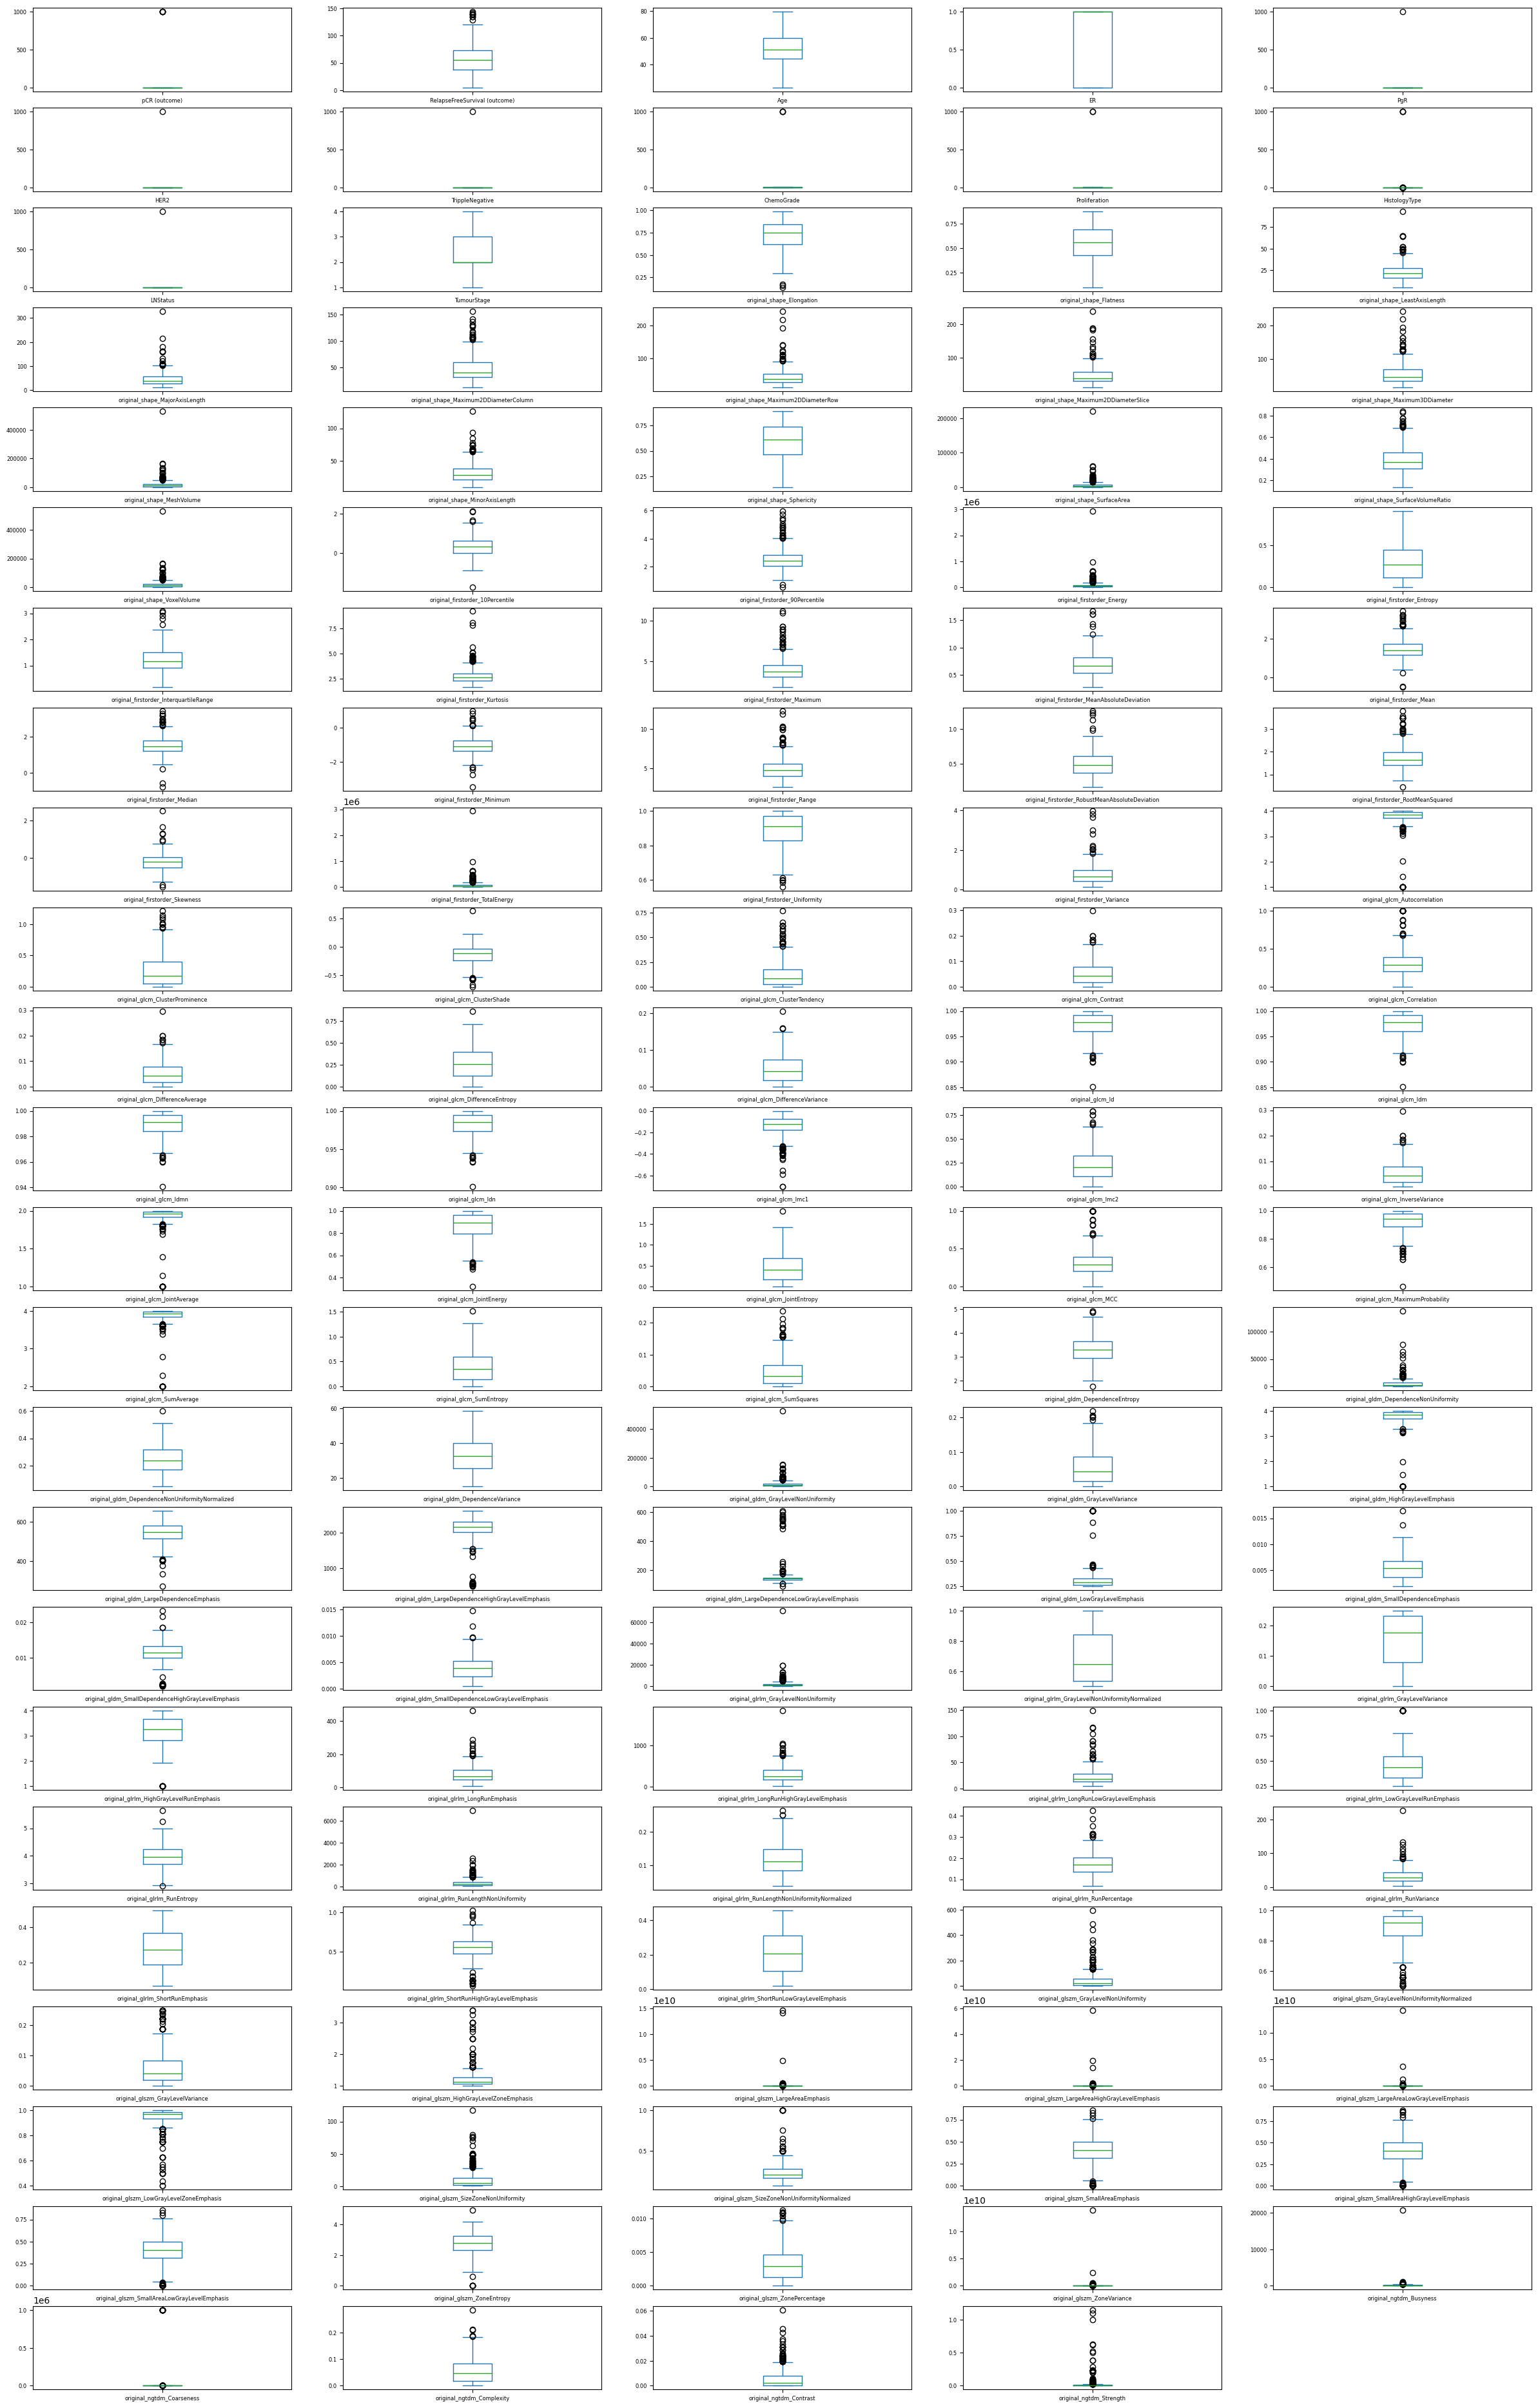

In [87]:
# boxplot for all features
all_df.plot(kind='box', subplots=True, layout=(25, 5), sharex=False,
            sharey=False, fontsize=6, figsize=(30, 50));

## Data pre-processing

#### Data imputation

- Dropping rows which has several missing values

In [88]:
# for now, we only delete rows which has 3 missing values, row 258 only has 2 missing values
# note that excel sheet starts from row 2 while dataframe starts from index 0
# all_df.drop([218, 253, 258, 287])
all_df = all_df.drop([218, 253, 285])

# retain the original dataset with ID column to be used in the future
dataset_ID = all_df['ID']
all_df.drop('ID', axis=1, inplace=True)

- Using most frequent values, KNN and multivariate imputer respectively

In [89]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index)

new_df = all_df.replace(999, np.NaN)
column_names = new_df.columns

k_imp = KNNImputer()
k_imputed_array = k_imp.fit_transform(new_df)

multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# loop through all the missing values rows and columns and impute the data with round up function
for i in range(len(missing_values_index[0])):
    row = missing_values_index[0][i]
    col = missing_values_index[1][i]
    k_imputed_array[row][col] = np.round(k_imputed_array[row][col])
    multi_imputed_array[row][col] = np.round(multi_imputed_array[row][col])
    print(k_imputed_array[row][col], multi_imputed_array[row][col])

# convert to dataFrame
k_imputed_df = pd.DataFrame(k_imputed_array, columns=column_names)
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

# write imputed dataframe into excel sheet
k_imputed_df.to_excel('./knnImputedDataset.xlsx', sheet_name='Sheet 1', index=False)
multi_imputed_df.to_excel('./multivariateImputedDataset.xlsx', sheet_name='Sheet 1', index=False)

0.0 0.0
3.0 3.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0


## Feature normalisation